In [ ]:
# netowrks
import networkx as nx
import igraph as ig

# data processing
import pandas as pd
import numpy as np

#some functions to make our lifes easier
import sys
sys.path.append("../")
from common_functions import *

# viz
#import pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns

# gzip
import gzip


In [ ]:
G = nx.read_adjlist('soc-Epinions1.txt')

In [16]:
# Path to file
file_path = 'soc-Epinions1.txt.gz'

# Initialize a directed graph
G = nx.DiGraph()

# Load the edge list into the directed graph
with gzip.open(file_path, 'rt') as f:
    # Skip header lines that start with '#'
    edges = [line.strip().split('\t') for line in f if not line.startswith('#')]
    # Add edges to the graph
    G.add_edges_from((int(src), int(dst)) for src, dst in edges)

# Basic graph statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_directed = G.is_directed()

# Print basic graph statistics
print("Total Nodes:", num_nodes)
print("Total Edges:", num_edges)
print("Is Directed:", is_directed)

Total Nodes: 75879
Total Edges: 508837
Is Directed: True


In [17]:
# Extract the largest Weakly Connected Component (WCC)
# For a directed graph, weakly connected components treat edges as undirected for connectivity purposes
largest_wcc = max(nx.weakly_connected_components(G), key=len)

# Create a subgraph of the largest WCC
G_wcc = G.subgraph(largest_wcc).copy()

# Statistics for the largest WCC
wcc_num_nodes = G_wcc.number_of_nodes()
wcc_num_edges = G_wcc.number_of_edges()

# Print WCC statistics
print("Nodes in largest WCC:", wcc_num_nodes)
print("Edges in largest WCC:", wcc_num_edges)

Nodes in largest WCC: 75877
Edges in largest WCC: 508836


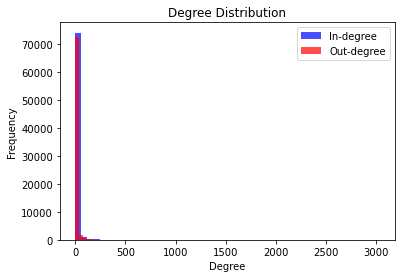

In [18]:
# Compute in-degree and out-degree distributions
in_degrees = [G_wcc.in_degree(n) for n in G_wcc.nodes()]
out_degrees = [G_wcc.out_degree(n) for n in G_wcc.nodes()]

# Plot in-degree distribution
plt.hist(in_degrees, bins=50, color='blue', alpha=0.7, label='In-degree')
plt.hist(out_degrees, bins=50, color='red', alpha=0.7, label='Out-degree')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("Degree Distribution")
plt.show()

In [19]:
# Calculate the average clustering coefficient
avg_clustering = nx.average_clustering(G_wcc.to_undirected())  # Convert to undirected for clustering
print("Average Clustering Coefficient:", avg_clustering)

Average Clustering Coefficient: 0.1377600044367361


In [ ]:
# Calculate the average shortest path length
# This can be computationally intensive; only use on smaller graphs or expect it to take time
try:
    avg_shortest_path_length = nx.average_shortest_path_length(G_wcc)
    print("Average Shortest Path Length:", avg_shortest_path_length)
except Exception as e:
    print("Error calculating shortest path length:", e)

In [ ]:
# Degree centrality
degree_centrality = nx.degree_centrality(G_wcc)
print("Top 5 nodes by degree centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

# Betweenness centrality (for larger graphs, consider approximations)
betweenness_centrality = nx.betweenness_centrality(G_wcc, k=100, seed=42)  # Using sample for speed
print("Top 5 nodes by betweenness centrality:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

In [ ]:
# Calculate assortativity coefficient
assortativity = nx.degree_assortativity_coefficient(G_wcc)
print("Assortativity Coefficient:", assortativity)

In [ ]:
nx.draw_networkx(G, node_size=1000, node_color='lightblue', with_labels=True, font_size=8)